** model energy consumption of from record data. **
written by fbb for NYU CUSP computing 
June 2017

In [1]:
import pandas as pd
import os
import pylab as pl
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as smf
import emcee
from scipy.cluster.vq import whiten

%pylab inline

pl.rcParams['figure.figsize']= (10,10)

Populating the interactive namespace from numpy and matplotlib


# Motivation 
model the energy consumption from record data. Estimate the robustness of your model and your model uncertanities in an MCMC environment. Use the modules *emcee* to implement MCMC and *corner* to visualize it

# Instructions 

follow the setup in PUI2016 HW6, where you explored the likelihood surface  of the energy_consumed *vs* number_of_units space. remember to include a figure caption **for every figure** that describes what is plotted and how it should be interpreted, and [basic PEP8 compliance as in PUI2016](https://github.com/fedhere/PUI2016_fb55/blob/master/PEP8MinimalRequirements.md)

(Notice the imports  above: you should probably use all the packages that I imported and used or equivalent packages/functions!m)

1. prepare the data by removing outliers (some choices where indicated in the solution of HW 6)

2. estimate the errors on the energy measurements: assume Poisson statistics on each measurement that is included in the formula for the energy 

3. find the analytical solution of the linear fit of energy to number_of_units in log-log space (log10(energy) *vs* log10(number_of_units))

4. create a likelihood model based on chi-square for a line fit of units to energy: you can follow [this example in the ENCSS documentation](http://dan.iel.fm/emcee/current/user/line/#maximum-likelihood-estimation) (almost literally) - just like in this example include in the fit a parameter that accounts for possible underestimation of the errors (the $f$ parameter)

5. for a second degree polynomial model of the form $energy = a x^2 + b x + intercept$ estimate your  model parameters and their confidence intervals (as the median and 16% and 84% percentile of the posterior distribution) with an Affine Invariant MCMC and plot the posterior distributions (with corner.py). Use the linear coefficient and intercept found in the analytical solution with a=0 as the starting point for the walkers ensemble (with small perturbations). (Continue to follow [the example above](http://dan.iel.fm/emcee/current/user/line/#maximum-likelihood-estimation), with appropriate modification for a polynomial deg=2 instead of a line fit model)

6. chose 5 parameters from the set of record data available through Pluto or Local Law 84 and fit a multivariate linear model to the energy data. Correct your uncertainties by the correction factor you estimated in your earlier model

7. fit a multivariate linear model to the data (for example with statsmodels.api.formula)

8. find the best model parameters and their uncertainties (as the median, 16th and 84th percentile of the posterior distributions) in an MCMC (Affine Invariant) environment using the analytical solution as a starting point, and plot the posterior distributions (with corner.py).  Indicate in the plot the analytical solution


# Data

data on Energy consumption can be found from the Local Low 84 data here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z , but this dataset does not have 

information on the building can be found in the PLUTO dataset.

In [207]:
#set en env variable UIDATA
%set_env UIDATA os.getenv("PUIDATA")
os.getenv("PUIDATA")

env: UIDATA=os.getenv("PUIDATA")


'/Users/fbianco/science/Dropbox//UI/PUIdata'

download, move data to a data directory pointed to by the env variable  UIDATA, and read data in 

In [ ]:
[...]

## checking the content of the datasets

In [4]:
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [5]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

clean up columns I am not using

In [6]:
nrg.drop(['Co-reported BBL Status',
       'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], axis=1, inplace=True)

In [7]:
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResidFAR', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'Version', 'XCoord', 'YCoord',
       'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
       'geometry'], axis=1, inplace=True)

### converting  the relevant columns to numeric values and throwing away spurious entries

In [8]:
[...]

## merging Pluto and LL84 dataframes

In [37]:
bblnrgdata = pd.merge(nrg, bsize, how='inner', on=['BBL'])
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BldgArea,GarageArea,NumBldgs,NumFloors,ResArea,RetailArea,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360,440360,1,2.0,0,0,0,1,1987
1,1.004370e+09,NaN,NaN,52390,0,1,4.0,0,0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200,0,1,32.0,0,5378,0,56,1977
3,1.009220e+09,NaN,NaN,98260,0,1,19.0,98260,0,148,148,1963
4,1.007400e+09,NaN,68329.0,48800,0,1,5.0,0,0,0,1,1920


calculate energy from energy by sq foot and area

In [ ]:
[...]

In [209]:
bblnrgdata.describe()

,BBL,EUIonFeetSq,floorArea_ftsq,BldgArea,GarageArea,NumBldgs,NumFloors,ResArea,RetailArea,UnitsRes,UnitsTotal,YearBuilt,nrg
count,6.492000e+03,5.077000e+03,5.579000e+03,6.492000e+03,6492.000000,6492.000000,6492.000000,6.492000e+03,6.492000e+03,6492.000000,6492.000000,6492.000000,5.069000e+03
mean,1.012037e+09,1.161758e+03,2.139771e+05,2.139001e+05,4848.563463,1.466420,15.027341,9.888482e+04,9.216202e+03,96.906038,108.948090,1936.754159,2.136455e+08
std,5.665916e+06,4.272501e+04,3.248771e+05,3.737116e+05,24807.081857,2.833588,10.208362,2.082908e+05,4.396778e+04,248.653949,252.170956,114.942467,5.245490e+09
min,1.000010e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,1.008180e+09,6.590000e+01,7.154450e+04,6.569800e+04,0.000000,1.000000,7.000000,0.000000e+00,0.000000e+00,0.000000,17.000000,1920.000000,5.865608e+06
50%,1.012344e+09,8.300000e+01,1.148450e+05,1.086070e+05,0.000000,1.000000,13.000000,5.717150e+04,1.393000e+03,49.000000,58.000000,1930.000000,9.347373e+06
75%,1.015438e+09,1.040000e+02,2.180765e+05,2.120000e+05,0.000000,1.000000,19.000000,1.175100e+05,8.861500e+03,106.250000,116.000000,1965.000000,1.905119e+07
max,1.022500e+09,3.018493e+06,9.515627e+06,1.343508e+07,614267.000000,158.000000,88.000000,8.367942e+06,2.192088e+06,8759.000000,8805.000000,2015.000000,3.501452e+11


## removing outliers

In [217]:
#removing obvious outliers
bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                        (bblnrgdata.UnitsTotal<5e3) * (bblnrgdata.nrg < 1e11)]

## propagation of errors on the log:
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{{10}}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [221]:
errorsInLogNrg = np.abs(bblnrgdataCut.error / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(bblnrgdataCut.UnitsTotal**0.5 / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [222]:
bblnrgdataCut['nrglog'] = np.log10(bblnrgdataCut.nrg)
bblnrgdataCut['UnitsTotallog'] = np.log10(bblnrgdataCut.UnitsTotal)
bblnrgdataCut['errorlog'] = (bblnrgdataCut['errorsunits']**2 + bblnrgdataCut['errorsnrg']**2)**0.5

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

# Model 1: linear model

## analytical solution

linear least square solution

In [ ]:
A = np.vstack((np.ones_like(bblnrgdataCut.UnitsTotallog), bblnrgdataCut.UnitsTotallog)).T
C = np.diag(bblnrgdataCut.errorlog * bblnrgdataCut.errorlog)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, bblnrgdataCut.nrglog)))

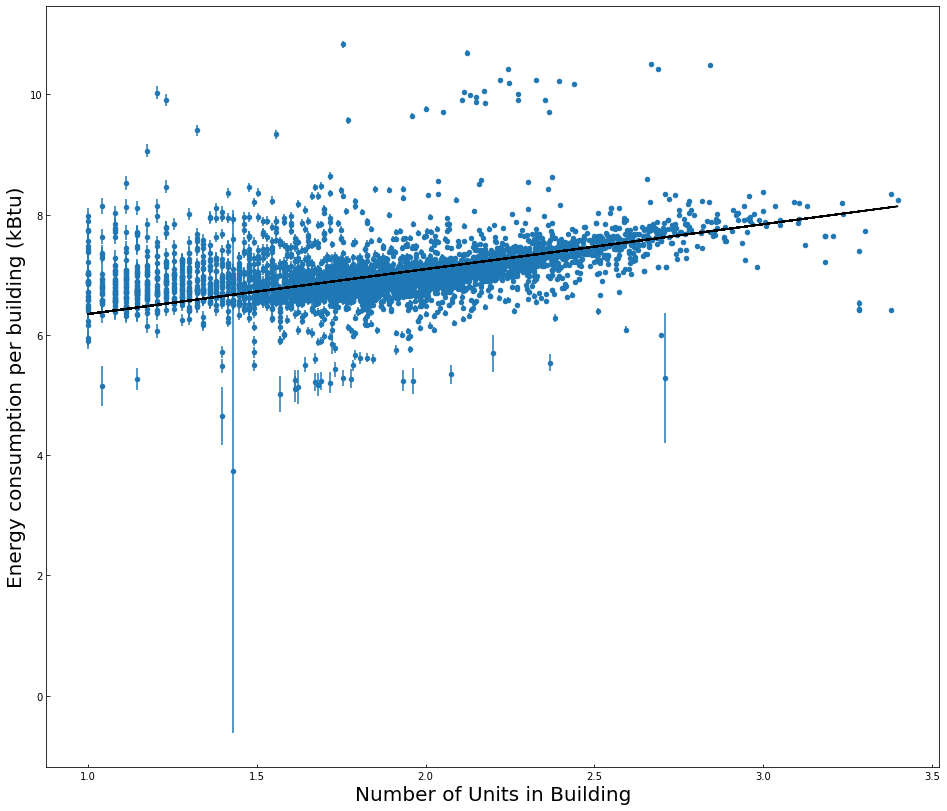

In [226]:
ax = bblnrgdataCut.plot(kind='scatter', y='nrglog', x='UnitsTotallog', yerr="errorlog",
                   marker='o',  figsize=(16, 14))#, loglog=True)
ax.plot(bblnrgdataCut.UnitsTotallog, b_ls + m_ls * bblnrgdataCut.UnitsTotallog, 'k-')
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

## Define the model, a log likelihood function, and set priors.

In [228]:
[...]

## set up the MCMC and run it

In [229]:
[...]

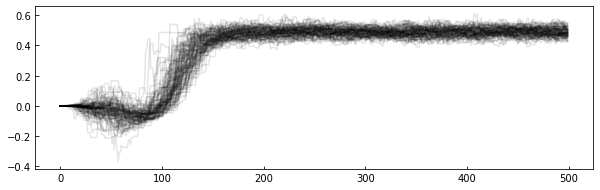

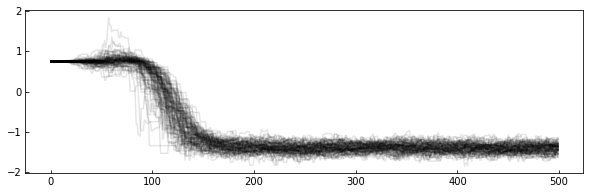

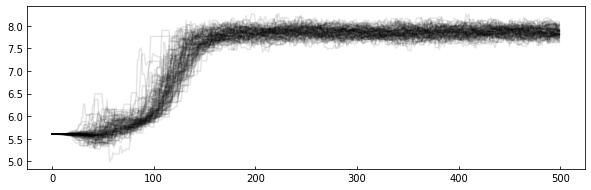

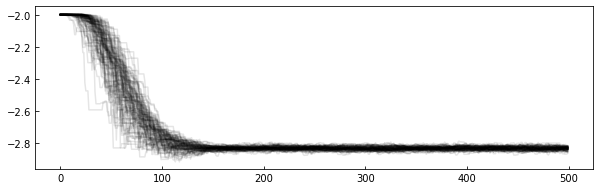

In [230]:
#check the walker and find the burn-in point
[...]

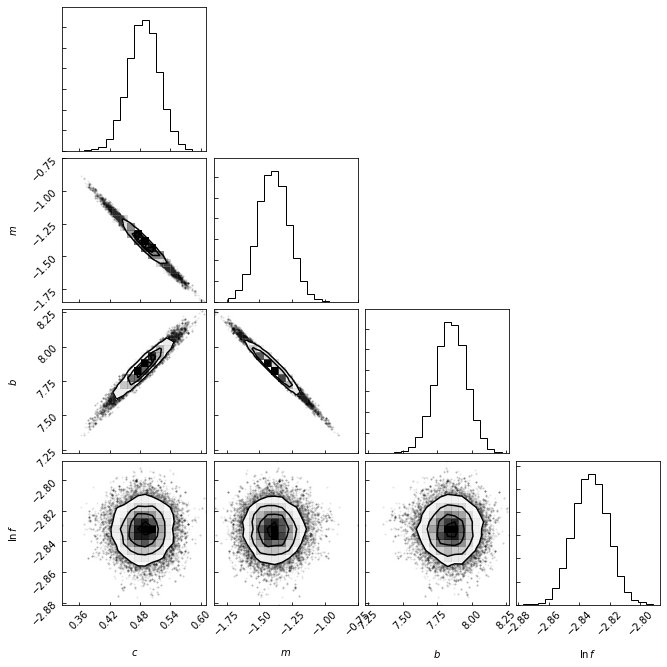

In [232]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$c$", "$m$", "$b$", "$\ln\,f$"],
                      truths=[0, m_ls, b_ls, np.log(1)])
fig.savefig("triangle.png")


In [1]:
#plot result

# Model 2: multivariate linear regression
chose 5 variables and try a linear regression on the 5 variables

In [ ]:
[...]

## Define model, likelihood function, priors

In [182]:
[...]

## Preprocessing: because this model is multivariate it is important to whiten the data!

In [183]:
[...]

In [185]:
est = smf.ols(formula=...

0.15192598990003611

## run the simulation

In [195]:
[...]

In [2]:
#remember to use caption and describe what  you are doing and what you see in your plots!